In [ ]:
#| default_exp t2s
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| exporti
import torch
import torch.nn as nn
from torch.profiler import record_function

In [ ]:
#| exporti
from pathlib import Path
import pylab as plt
import pandas as pd

In [ ]:
#| exporti
import whisper
from spear_tts_pytorch.train import *
from spear_tts_pytorch.modules import *

In [ ]:
datadir = Path('/mnt/stoks-txts/')

# Dataset

## Load the data

In [ ]:
data = pd.DataFrame(dict(stoks=[str(x) for x in Path(datadir).rglob('*.stoks')]))

In [ ]:
data['text'] = data['stoks'].apply(lambda x: Path(x).with_suffix('.txt').read_text())

In [ ]:
data

,stoks,text
0,/mnt/stoks-txts/medium/911report_32_64kb-2.stoks,Selection and Selection for 9-11. Twelve of t...
1,/mnt/stoks-txts/medium/thousand_nights_vol03_1...,"smite these people's necks, their troops will..."
2,/mnt/stoks-txts/medium/21stcenturypolicing_03_...,95% are law-abiding. This becomes a self-rein...
3,/mnt/stoks-txts/medium/rewardsandfairies_11_ki...,"That's foolishness, he says. Who cares where ..."
4,/mnt/stoks-txts/medium/factorygirlsdanger_scot...,into her old position and upon terms and cond...
...,...,...
140654,/mnt/stoks-txts/small/floridasketch_03_torrey_...,"And, as he sprinted up and down the sand in h..."
140655,/mnt/stoks-txts/small/shirley_47_bronte_64kb-8...,"had been two hours before."" This change, acco..."
140656,/mnt/stoks-txts/small/goldenbowl_4-26_james_64...,carefully thinking of it and watching it. But...
140657,/mnt/stoks-txts/small/millonthefloss_19_eliot_...,"this time of his trouble, they never became c..."


In [ ]:
print(f"{len(data) * 26 / 3600} hours of (auto)transcribed speech") # average sample length is 26s

1015.8705555555556 hours of (auto)transcribed speech


In [ ]:
#| exporti
def load_data(path):
    data = pd.DataFrame(dict(stoks=[str(x) for x in Path(path).rglob('*.stoks')]))
    data['text'] = data['stoks'].apply(lambda x: Path(x).with_suffix('.txt').read_text())
    return data

## Prepare the datasets

In [ ]:
data = load_data(datadir)

In [ ]:
#| exporti
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
            
    def __repr__(self):
        return f"<Dataset: {len(self)} samples>"
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        Stoks = torch.load(row['stoks'], map_location='cpu')[0,:,0]
        Ttoks = self.tokenizer.encode(row['text'])
        return F.pad(torch.tensor(Ttoks), (0, 200 - len(Ttoks)), value=self.tokenizer.eot).to(torch.long), F.pad(Stoks, (0, 1500 - len(Stoks)), value=1024).to(torch.long)

In [ ]:
tokenizer = whisper.tokenizer.get_tokenizer(multilingual=True)

In [ ]:
val_data, train_data = data[:300], data[300:]
val_ds = SADataset(val_data, tokenizer)
val_ds

<Dataset: 300 samples>

In [ ]:
train_ds = SADataset(train_data, tokenizer)
train_ds

<Dataset: 140359 samples>

In [ ]:
train_ds[0]

(tensor([  467,   390,   720, 35442,   337,  1419,   586,   572, 30705,   281,
          6479,   720,  8913,    13,  1240, 40791,   439,   720, 43271,   337,
           472, 46607,  7563,    11,   293,    11, 16005,    11,  3574,  1314,
            13,   583,   750,  2729,   472,   574,   646,   490,   264,  4838,
            11,   445,   490,   264,  1036,   935,   412,   597,   264,  2853,
           727,   312,  1612,    11,   293,    11, 16124,   257, 25838,   295,
         35172,  4877, 18864,   322,   264,  1823,    11,   750, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 5

In [ ]:
#| export
def load_datasets(path):
    tokenizer = whisper.tokenizer.get_tokenizer(multilingual=True)
    data = load_data(path)
    
    val_data, train_data = data[:300], data[300:]

    return SADataset(train_data, tokenizer), SADataset(val_data, tokenizer)

# Modeling

In [ ]:
#| export
class TSARTransformer(nn.Module):
    def __init__(self, width=384, depth=6, n_head=6):
        super(TSARTransformer, self).__init__()

        self.encoder = Encoder(length=200, codes=50364, width=width, n_head=n_head, depth=depth)
        self.decoder = Decoder(length=1500, codes=1024, width=width, n_head=n_head, depth=depth)

    def forward(self, Ttoks, Stoks, loss=True):
        with record_function("encoder"):
            xenc = self.encoder(Ttoks.to(torch.long))
        with record_function("decoder"):
            logits = self.decoder(Stoks, xenc)
        if loss is not None:
            with record_function("loss"):
                loss = F.cross_entropy(logits.reshape(-1,logits.shape[-1]), Stoks.view(-1))
        return logits, loss

In [ ]:
#| export
def make_model(size):
    if size == 'micro':
        return TSARTransformer(depth=3)
    elif size == 'tiny':
        return TSARTransformer(depth=4)

samples,train,val,time
20000,2.93531,3.08976,02:06
40000,2.40885,2.46782,03:47
60000,2.24459,2.34386,05:41
80000,2.25632,2.26977,07:34
100000,2.12768,2.20723,09:35
120000,2.07301,2.15234,11:30
140000,2.11128,2.12581,13:33
140368,2.09136,2.12533,13:36


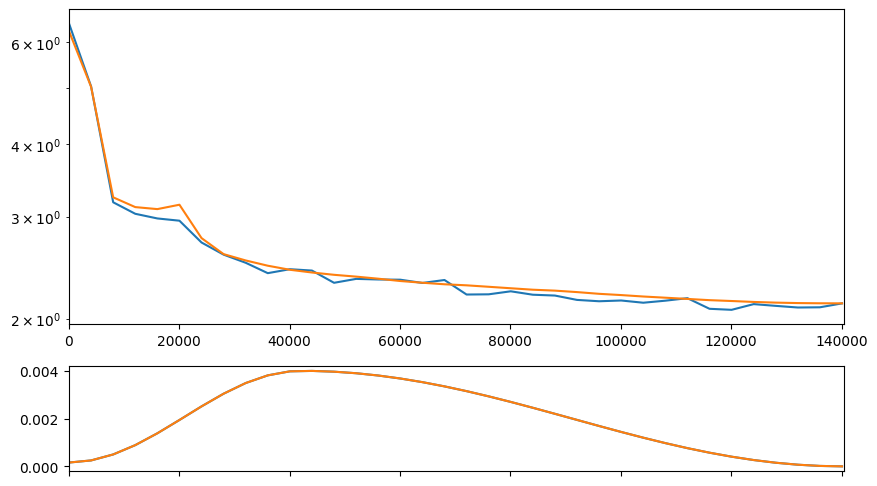

In [ ]:
# make sure it works at all
model = TSARTransformer(depth=3).cuda()
train("/scrach/tsar-checkpoints", model, train_ds, val_ds, half=True, bs=16, lr=4e-3, epochs=1,
      table_row_every_iters=20000, run_valid_every_iters=4000)

samples,train,val,time
80000,2.56269,2.83687,22:59
160000,2.26247,2.39995,41:30
240000,2.16594,2.27455,47:38
320000,1.96548,2.00825,54:08
400000,1.86841,1.88929,1:01:07
480000,1.82314,1.85076,1:07:27
560000,1.83932,1.81487,1:13:35
640000,1.80581,1.79792,1:19:55
720000,1.74787,1.78892,1:26:10
800000,1.79779,1.78353,1:32:32


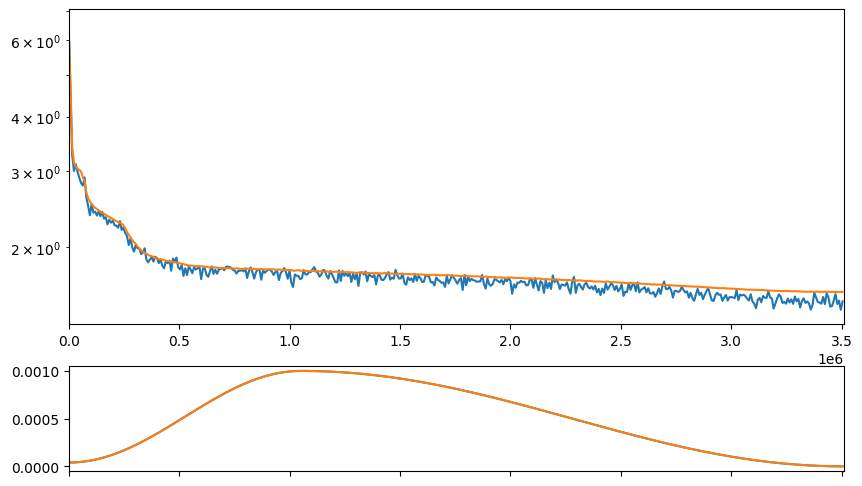

In [ ]:
model = TSARTransformer(depth=3).cuda()
train("tsar-140k", model, train_ds, val_ds, half=True, bs=8, lr=1e-3, epochs=25, warmup=0,
      table_row_every_iters=80000, run_valid_every_iters=8000)

In [ ]:
torch.save(model.state_dict(), 'tsar-140k-25e-ce1.58.pth')

samples,train,val,time
80000,2.31314,2.41210,04:53
160000,2.16040,2.25076,09:42
240000,2.09020,2.14504,14:51
320000,1.95545,2.00177,19:52
400000,1.83738,1.87890,24:42
480000,1.75185,1.82079,29:49
560000,1.72557,1.78461,34:49
640000,1.73570,1.76621,39:40
720000,1.69044,1.75392,44:40
800000,1.67324,1.73999,49:35


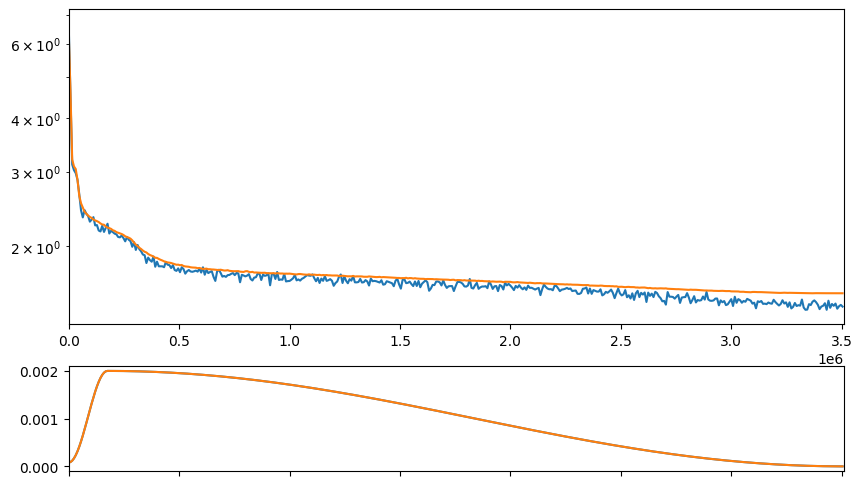

In [ ]:
# Whisper tiny sized model
model = TSARTransformer(depth=4).cuda()
train("tsar-140k-4l", model, train_ds, val_ds, half=True, bs=16, lr=2e-3, epochs=25, warmup=0, pct_start=0.05,
      table_row_every_iters=80000, run_valid_every_iters=8000, chkpt_every_iters=80000)

In [ ]:
torch.save(model.state_dict(), 'tsar-140k-4l-25e-ce1.55.pth')

# Sample from the model

In [ ]:
model = TSARTransformer(depth=4).cuda()
model.load_state_dict(torch.load('tsar-140k-4l-25e-ce1.55.pth')) #'/scrach/tsar-checkpoints/1480000.pt')) #  tsar-32k-60e-ce1.87.pth
model.eval().cuda();

In [ ]:
whmodel = whisper.load_model('tiny.en')

In [ ]:
from spear_tts_pytorch.extract_stoks import RQBottleneckTransformer
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                              threshold_ema_dead_code=0.1)
vqmodel.load_state_dict(torch.load('./vqmodel2-tiny-1000h.pth'))
vqmodel.eval().cuda();

In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(val_ds, batch_size=16)

In [ ]:
bx, by = [x.cuda() for x in next(iter(dl))]

In [ ]:
bx.shape, by.shape

(torch.Size([16, 200]), torch.Size([16, 1500]))

In [ ]:
with torch.no_grad():
    logits, loss = model(bx, by)
loss

tensor(1.4946, device='cuda:0')

In [ ]:
(by[5] == 1024).sum()

tensor(141, device='cuda:0')

In [ ]:
by[5,:-141]

tensor([ 78, 980, 980,  ..., 216, 690, 216], device='cuda:0')

In [ ]:
x = vqmodel.rq.layers[0]._codebook.embed[0,by[5,:-141].to(torch.long).view(-1)]
x = F.pad(x, (0, 0, 0, 1500-len(x)))
orig_embs = vqmodel.ln_post(vqmodel.out_blocks((vqmodel.rq.layers[0].project_out(x) + vqmodel.positional_embedding).unsqueeze(0)))
whmodel.decode(orig_embs, whisper.DecodingOptions(language='en'))

[DecodingResult(audio_features=tensor([[-1.7002, -1.3105, -0.0891,  ..., -1.5332,  0.6606, -3.5156],
         [-1.5342, -0.3982,  1.1299,  ..., -1.8730, -0.1315, -4.1523],
         [-1.5029, -0.5972,  0.6626,  ..., -1.5752, -0.1542, -4.1172],
         ...,
         [-0.2218,  1.3877,  0.6792,  ...,  1.5840, -1.5488, -0.7349],
         [-0.4180,  1.5811,  0.3328,  ...,  2.4277, -1.4521, -0.7466],
         [-0.7339,  1.4521, -0.0561,  ...,  2.8633, -1.2754, -0.6807]],
        device='cuda:0', dtype=torch.float16), language='en', language_probs=None, tokens=[50363, 1002, 673, 15847, 612, 11, 262, 34692, 10846, 561, 423, 284, 1394, 2491, 736, 290, 6071, 287, 262, 3024, 50619, 50619, 4252, 393, 287, 262, 23147, 6290, 286, 262, 937, 36194, 13, 50807, 50807, 1318, 318, 645, 406, 6, 46, 293, 321, 11, 691, 257, 21151, 11, 30690, 7815, 4314, 11, 290, 612, 318, 645, 14595, 13, 51145, 51145, 1439, 262, 670, 10616, 1660, 318, 1760, 319, 262, 4314, 416, 257, 14782, 12656, 13, 51371, 51371, 843, 3360

In [ ]:
def decode_stoks(stoks):
    stoks = stoks[:-(stoks == 1024).sum()]
    x = vqmodel.rq.layers[0]._codebook.embed[0,stoks.to(torch.long).view(-1)]
    x = F.pad(x, (0, 0, 0, 1500-len(x)))
    embs = vqmodel.ln_post(vqmodel.out_blocks((vqmodel.rq.layers[0].project_out(x) + vqmodel.positional_embedding).unsqueeze(0)))
    return whmodel.decode(embs, whisper.DecodingOptions(language='en'))

In [ ]:
print(tokenizer.decode(bx[5][torch.where(bx[5] != tokenizer.eot)]))

 If she cooked there, the missionary lady would have to keep running back and forth in the hot sun or in the pouring rain of the monsoon. There is no linoleum, only a damp, uneven stone floor, and there is no sink. All the work requiring water is done on the floor by a drainpipe, and sometimes, if the screen gets broken over the mouth of the drainpipe, toads come hopping in, and sometimes even


In [ ]:
# decode the quantized semantic tokens (they have some errors!)
print(decode_stoks(by[5])[0].text)
torch.save(by[5], 'gt-tokens.pth')

If she cooked there, the missionary lady would have to keep running back and forth in the hot sun or in the pouring rain of the monsoon. There is no L'Oleam, only a damp, uneven stone floor, and there is no sink. All the work requiring water is done on the floor by a drain pipe. And sometimes if the screen gets broken over the mouth of the drain pipe, toads come


In [ ]:
from fastprogress import progress_bar
# generate output using sampling, one token at a time
T=0.7
toks = []
for i in progress_bar(range(1500)):
    p, loss = model(bx[5:6], torch.tensor([toks]).cuda(), loss=None)
    last_p = p[0,-1]
    toks.append(torch.multinomial((last_p / T).softmax(-1), 1).item())
toks = torch.tensor(toks).cuda()
# btw. this is stupidly slow since it reruns the whole sequence every time, to be optimized later

In [ ]:
# decode the semantic tokens generated by the model (they have some more errors)
print(decode_stoks(toks)[0].text)
torch.save(toks, 'gen-tokens-T0.7.pth')

If she cooked there, the missionary lady would have to keep running back and forth in the hot sun or in the pouring rain of the monsoon. There is no L'Alim, only a damp, uneven stone floor, and there is no sink. All the work requiring water is done on the floor by a drying pipe. And sometimes, if the screen gets broken over the mouth of the drain pipe, towards
